In [1]:
!pip install gensim==3.8.3

In [2]:
!pip install wikipedia

In [3]:
import sys
import os
import itertools as it
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import wikipedia
import difflib
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

wikipedia.set_lang('en')



#### Load tweet data files and extract hashtags

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

hashtags = pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        hashtags = pd.concat([hashtags, df[['hashtags']]], axis=0)
        pbar.update(1)

In [ ]:
hashtags = hashtags[hashtags.astype(str)['hashtags'] != '[]'] # remove empties
hashtags

#### Build flat list of all hashtags

In [ ]:
hlist = [] 
for hashtag in hashtags['hashtags']:
    hlist.extend(eval(hashtag))

#### Count frequency of each hashtag and sort the list in descending order

In [ ]:
counted = Counter(hlist)
tf = sorted(dict(counted).items(), key=lambda x: x[1], reverse=True) # Sort hashtags by frequency in descending order
print(tf[:25])

#### For initial investigation, select only hashtags used more than 1000 times

In [ ]:
use_threshold = 1000
tf_popular = []
print('Length before: '+str(len(tf)))
for tag in tf:
    if  tag[1] >= use_threshold:
        tf_popular.append(tag)
print('Length after: '+str(len(tf_popular)))

#### Build a matrix of concurrent use of hashtags, correlate and visualise

In [ ]:
popular_hashtags = [item[0] for item in tf_popular]
hashtag_matrix = pd.DataFrame(0, index=popular_hashtags, columns=popular_hashtags).astype(int)

for item in hashtags['hashtags'].values:
    hashtag_list = eval(item)
    for a, b in it.permutations(hashtag_list, 2):
        if all([hashtag in popular_hashtags for hashtag in [a,b]]):
            hashtag_matrix.at[a, b] += 1
            
hashtag_matrix

In [ ]:
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

In [ ]:
# plot the correlation matrix
plt.figure(figsize=(25, 25))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

In [ ]:
correlations

#### Inspect a ranked list of correlated pairs of hashtags

In [ ]:
s = correlations.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

In [ ]:
so[97:200:2] # There are 97 hashtags in the popular list, so the first 97 entries are self-correlations.  Each pair is duplicated in the list, too

#### Use sklearn's CountVectorizer to one-hot encode the use of hashtags in each tweet

This is for all 200k hashtags. Needs to be sparse

In [ ]:
cv = skfe.text.CountVectorizer()
one_hot = cv.fit_transform(hashtags['hashtags'].apply(lambda x: " ".join(eval(x)) ))
feature_names = cv.get_feature_names()
hashtag_observations= pd.DataFrame.sparse.from_spmatrix(one_hot, index=hashtags.index, columns=cv.get_feature_names())

In [ ]:
hashtag_observations.info()

In [ ]:
hashtag_observations.sparse.density

#### Dimensionality Reduction
Can't use PCA on a sparse matrix, so use TruncatedSVD instead. The only difference is that PCA would 'center' the data first.

In [ ]:
svd = skd.TruncatedSVD(n_components=100, random_state=32864)
svd.fit(hashtag_observations)
print(svd.explained_variance_ratio_.sum())
svd_comps = svd.components_

In [ ]:
plt.figure()
plt.bar([i for i in range(len(svd.explained_variance_ratio_))], svd.explained_variance_ratio_)
plt.show()

#### Attempt to establish which hashtags are significant for each component of the SVD, and create topics based on these sets

In [ ]:
significant = 0.3
print('Correlated: \t Anticorrelated:')
for j, comp in enumerate(svd_comps):
    if any(np.abs(comp)>significant):
        print(str(j) + ': ' + str([feature_names[i] for i in range(len(feature_names))
                                   if comp[i]>significant])+'\t'+str([feature_names[i] 
                                                                      for i in range(len(feature_names)) 
                                                                      if comp[i]<-significant]))

In [ ]:
topics = []
themes = []
for comp in svd_comps:
    if any(comp>significant):
        theme_list = [feature_names[i] for i in range(len(feature_names)) if comp[i]>significant]
        themes.extend(theme_list)
        topics.append(theme_list)
themes = list(set(themes))
print(topics)

In [ ]:
translation_matrix = pd.DataFrame()
translation_matrix['hashtags'] = themes
translation_matrix.head()

#### Attempt to get wikipedia pages relating to each hashtag in each topic

In [ ]:
tags_to_pages = [] # Create a dict that will map hashtags to wikipedia page titles
tags_to_search = []

print('Hashtag: -> Suggestion: -> Search Result:')
for theme in themes:
    suggestion = wiki.suggest(theme) # This returns a "did you mean"-style alternative to the searching hashtag, this can be useful in identifying an accurate subject match
    if suggestion is not None:
        # If an alternative is suggested, need to decide if the alternative is going to be better than the hashtag
        # Generally, issues in identifying pages correctly arise from a lack of spaces in multi-word hashtags, 
        # So the following 2 lines of code only accept the alternative if it is the same as the hashtag but punctuated with spaces.
        # Suggested alternatives which in any way alter the letters contained in the hashtag are rejected, and the hashtag used instead
        diff = list(difflib.ndiff(theme, suggestion)) 
        if any([item != '+  ' for item in [diff[i] for i in range(len(diff)) if diff[i][0] is not ' ']]):
            search_term = theme
        else:
            search_term = suggestion
    else:
        search_term = theme
    
    search_results = wiki.search(search_term, results=3)
        
    print(theme  + ' -> ' + str(suggestion) + ' -> ' + str(search_results)) # print the top result
    #print('For theme {}, using search term {}.'.format(theme, search_term))
    if len(search_results)>0:
        tags_to_pages.append(search_results[0])
        tags_to_search.append(search_results)
    else:
        tags_to_pages.append(None)
        tags_to_search.append(None)
    
translation_matrix['pages'] = tags_to_pages
translation_matrix['search_results'] = tags_to_search

In [ ]:
translation_matrix

In [ ]:
pages = []

for topic in topics:
    pages.append([translation_matrix.loc[translation_matrix['hashtags']==theme,'pages'].values[0] for theme in topic])

pages

#### Attempt to bridge overlapping topics

In [ ]:
bridged_topics = []

for i, topic in enumerate(pages):
    truth_table = [len(set(theme_list).intersection(topic)) > 0 for theme_list in bridged_topics]
    #print(truth_table)
    if any(truth_table):
        idx = truth_table.index(True)
        merged_topic = list(set(bridged_topics[idx])|set(topic))
        bridged_topics[idx] = merged_topic
        
    else:
        bridged_topics.append(topic)
    

bridged_topics

In [ ]:
other = []
for page in other_theme:
    full_page = wikipedia.page(page).content
    full_page = full_page.split("== See also ==")[0]    #Remove text after "See also"
    page_split = re.split("\. |\.\n",str(full_page))
    
    final_page_split = []    
    for sentence in page_split:
        if len(sentence) >= min_characters_sentence:
            final_page_split.append(sentence)
    final_page_split = final_page_split[0:20]
    other.append(final_page_split) 
    #Append sentences to final other_theme corpus
    #for sentence in final_page_split:
    #    training_corpus = training_corpus.append({'Text':sentence, 'Theme':theme, 'Source':'Wikipedia'}, ignore_index=True)

#### Here we need some human input to check the topics etc, perhaps join some more...

In [4]:
topics = [['Coronavirus disease 2019', 'Lockdown'], 
['Artificial intelligence', 'Computer security', 'Financial technology', 'Internet of things', 'Robotics'], 
['Data science', 'Machine learning'],
['Information security'],
['Blockchain', 'Payment', 'Cryptocurrency'],
['Innovation', 'Technology'],
['Data', 'General Data Protection Regulation'],
['Brexit'],
['Privacy'],
['Startup company'],
['China'],
['5G'],
['Digital transformation'],
['Mental health'],
['2020 Beirut explosion', 'Lebanon', 'Beirut'],
['2020 Belarusian protests'],
['Journalism', 'Travel'], 
['Business'],
['Apple Inc.', 'Final Cut Pro X', 'Video'],
['Augmented reality', 'Vertual reality'], 
['Property', 'Real estate'], 
['Architecture', 'Design'],
['Climate change', 'Environmental, social and corporate governance', 'Sustainability'],
['Health care'],
['Cybercrime', 'Ransomeware', 'Malware'],
['Facebook', 'Social media'],
['Other (philosophy)', 'Lexie Brown', 'Baseball broadcasting firsts', 'Rhydlewis', 'Moisés Alou',
    '3rd Weather Squadron', 'Gifty Acheampong', 'Kollines', 'Access Now, Inc. v. Southwest Airlines Co.', 'Australia Made Preference League',
    'Buddhist councils', '2009–10 Olympique de Marseille season', '2013 Tour of Flanders', 'Michael Britten','Frits Potgieter',
    'First Among Sequels', 'Lend Lease Project Management & Construction', 'B. M. Choudary', 'USS La Moure County (LST-1194)', 'John McGinnis', 
    'Valerie Maxfield', 'Lydian language', 'Nathan Alcock', 'İzbırak, Midyat', 'Leonhard Baldner',
    'Julian H. Scaff', "The Boy's Doin' It", "America's Got Talent (season 8)", 'Mass media in the Czech Republic', 'Rear-eject haul truck bodies',
    'Davy Crockett, Indian Scout', 'Métis flag', 'The Second Scroll', 'Institute of Physics and Engineering in Medicine', 'Honda Mobilio',
    'Forced marriage', 'Wetaskiwin', 'Mort Hoppenfeld', 'Saddam Hussein and al-Qaeda link allegations', 'Crane Creek (Melbourne, Florida)']]


Adapted from Martin's code ref:  https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [5]:
min_characters_sent = 3   #Min characters in a paragraph (inclusive)
min_characters_word = 3     #Min characters in a word (inclusive)
test_size = 0.2     #Fraction of corpus to keep back for testing

['Coronavirus disease 2019_Lockdown', 'Artificial intelligence_Computer security_Financial technology_Internet of things_Robotics', 'Data science_Machine learning', 'Information security', 'Blockchain_Payment_Cryptocurrency', 'Innovation_Technology', 'Data_General Data Protection Regulation', 'Brexit', 'Privacy', 'Startup company', 'China', '5G', 'Digital transformation', 'Mental health', '2020 Beirut explosion_Lebanon_Beirut', '2020 Belarusian protests', 'Journalism_Travel', 'Business', 'Apple Inc._Final Cut Pro X_Video', 'Augmented reality_Vertual reality', 'Property_Real estate', 'Architecture_Design', 'Climate change_Environmental, social and corporate governance_Sustainability', 'Health care', 'Cybercrime_Ransomeware_Malware', 'Facebook_Social media', 'Other']


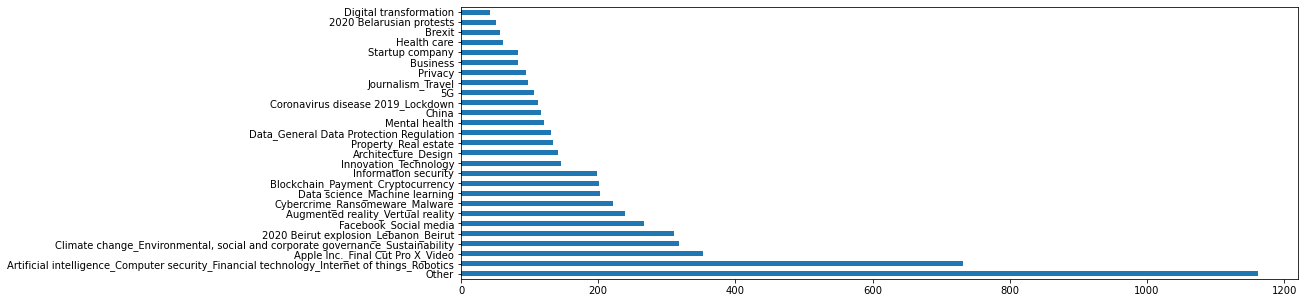

In [6]:
wiki_pages = topics
themes = ['_'.join(topic) for topic in topics]
del themes[-1]
themes.append('Other')

print(themes)

training_corpus = pd.DataFrame(columns=['Text','Theme','Source'])

for theme,page in zip(themes,wiki_pages):
    all_page = ''
    if isinstance(page, str):
        page=[page,]
    for p in page:
        full_page = wikipedia.page(p).content
        full_page = full_page.split("== See also ==")[0]    #Remove text after "See also"
        all_page += full_page
    
    page_split = str(all_page).split("\n")
    #page_split = re.split("\. |\.\n",str(all_page))
    #print("Number of paragraphs before trimming = "+str(len(page_split)))

    #Only retain paragraphs with at least N characters to retain only proper paragraphs
    final_page_split = []    
    for sent in page_split:
        if len(sent) >= min_characters_sent:
            final_page_split.append(sent)

    n_docs_to_proc = len(final_page_split)
    #print("Number of paragraphs after trimming = "+str(n_docs_to_proc))

    #Append paragraphs to final corpus
    for sentence in final_page_split:
        training_corpus = training_corpus.append({'Text':sentence, 'Theme':theme, 'Source':'Wikipedia'}, ignore_index=True)

training_corpus['Theme'].value_counts().plot.barh(figsize=(15,5))
plt.show()

# Pre-process training data

In [7]:
# Clean the text - mainly used for processing html

from bs4 import BeautifulSoup

def cleanText(text):
#    text = BeautifulSoup(text, "lxml").text
#    text = re.sub(r'\|\|\|', r' ', text) 
#    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
#    text = text.replace('x', '')
    return text

training_corpus['Text'] = training_corpus['Text'].apply(cleanText)

In [8]:
train, test = train_test_split(training_corpus, test_size=test_size, random_state=42)
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if (len(word) >= min_characters_word) & (word not in stop_words) : tokens.append(word)
#            if (len(word) >= min_characters_word) : tokens.append(word)
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.Theme]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.Theme]), axis=1)


# Apply models

# # Distributed bag of words


In [9]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [10]:
#model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores) #Values from tutorial

model_dbow = Doc2Vec(dm=0, vector_size=500, negative=5, hs=1, min_count=2, sample=0, workers=cores) #My optimised values

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████████████████████████████████████████████████████████████████████████████████| 4622/4622 [00:00<?, ?it/s]


In [11]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████████████████████████████████████████████████| 4622/4622 [00:00<?, ?it/s]


Wall time: 18.1 s


In [12]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [27]:
# Distributed Bag of Words (DBOW) model
from sklearn.ensemble import GradientBoostingClassifier

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print('gbc_dbow Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('gbc_dbow Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

xgbc_dbow Testing accuracy 0.49480968858131485
gbc_dbow Testing F1 score: 0.4786976429130576


# Distributed memory


In [28]:
#model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)  #Values from tutorial

model_dmm = Doc2Vec(dm=1, dm_mean=0, vector_size=500, window=10, negative=5, min_count=1, workers=cores, alpha=0.1, min_alpha=0) #My optimised values

model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████████████████████████████████████████████████████████████████████████████████| 4622/4622 [00:00<?, ?it/s]


In [29]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████████████████████████████████████████████████████████████████████████████████| 4622/4622 [00:00<?, ?it/s]


Wall time: 24.9 s


In [30]:
# Distributed Memory (DM) model

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print('xgb_model_dmm Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('xgb_model_dmm Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

xgb_model_dmm Testing accuracy 0.2820069204152249
xgb_model_dmm Testing F1 score: 0.3033013547974553


# Combined model pairing

In [31]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_new = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [32]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [33]:
# Model Pairing method

y_train, X_train = get_vectors(model_new, train_tagged)
y_test, X_test = get_vectors(model_new, test_tagged)
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print('xgb_model_new Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('xgb_model_new Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

xgb_model_new Testing accuracy 0.38408304498269896
xgb_model_new Testing F1 score: 0.414625152711002


In [20]:
#Free up memory (not necessary for our small training sample)
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# Apply to tweets

In [ ]:
def get_vectors_apply(model, docs_to_classify):
    sents = docs_to_classify.values
    regressors = [model.infer_vector(doc.words, steps=20) for doc in sents]
    return regressors

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+", "", str(text)) #remove urls
    text = re.sub(r'\S+\.com\S+','',str(text)) #remove urls
    text = re.sub(r'\@\w+','',str(text)) #remove mentions
    text =re.sub(r'\#','',str(text)) #remove hashtags
    text = re.findall(r'[A-Za-z]+',str(text))
    text = ' '.join(text) 
    return text

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\cleaned tweets\cyber friends tweets'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
classifier_model = xgb_model
model = model_new

with tqdm(total=len(files), desc='Files') as pbar:
    i=0
    for file in files[:2]:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df = df[df.text != '']
        df['clean_tweet'] = df['text'].apply(lambda x: clean_text(x))
        test_tagged = df.apply(
            lambda r: TaggedDocument(words=tokenize_text(r['clean_tweet']), tags=[r.screen_name]), axis=1)
        X_test = get_vectors_apply(model, test_tagged)
        df['y_pred'] = classifier_model.predict(X_test)
        y_pred_score = classifier_model.predict_proba(X_test)
        df2 = pd.DataFrame(y_pred_score)
        df2.columns=classifier_model.classes_
        df2['score'] = df2.max(axis=1)
        df['score'] = df2['score']
        df3 = df[['tweet_id','screen_name', 'text', 'y_pred', 'score']].copy()
        df4 = pd.concat([df3, df2], axis=1)
        df3.to_csv('topic_modelled_'+str(i)+'.csv', index=False)
        df4.to_csv('all_topics_modelled_'+str(i)+'.csv', index=False)
        print(df4.head())
        pbar.update(1)
        i = i+1


# How are journalists interests are spread?

first we need to drop the row where the classification has been less than 0.5, then we can pool over user_name

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\Python Scripts\all_topics_modelled'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
ls = list(logreg_dmm.classes_)
ls.insert(0, 'screen_name')
df_totalled_topics = pd.DataFrame(columns=ls)

df_totalled_topics

In [ ]:
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df[~(df['score'] <= 0.5)] 
        df2 = df1.groupby('screen_name')['5g', 'IOT', 'ai', 'analyticsinvestment',
                                        'apple', 'banking', 'beirut', 'belarus', 'blacklivesmatter',
                                        'brexit', 'business', 'china', 'climatechange', 'cloud',
                                        'covid19', 'crypto', 'cryptocurrency', 'cybersecurity', 'data',
                                        'datascience', 'demconvention', 'economy', 'esg', 'fintech', 'gdpr',
                                        'healthcare', 'hongkong', 'infosec', 'insurance', 'iran', 'jobs', 'leadership',
                                        'machinelearning', 'mentalhealth', 'paymentsprivacy', 'phishing', 'podcast',
                                        'property', 'regtech', 'retail', 'robotics', 'socialmedia', 'startup',
                                        'sustainability', 'syria', 'vr', 'webinar', 'womenintech'].sum()
        df_totalled_topics = pd.concat([df_totalled_topics, df2])
        pbar.update(1)
df_totalled_topics.head()


In [ ]:
df_totalled_topics['total'] = df_totalled_topics.sum(axis = 1)

In [ ]:
df3 = df_totalled_topics[['5g', 'IOT', 'ai', 'analyticsinvestment',
                        'apple', 'banking', 'beirut', 'belarus', 'blacklivesmatter',
                        'brexit', 'business', 'china', 'climatechange', 'cloud',
                        'covid19', 'crypto', 'cryptocurrency', 'cybersecurity', 'data',
                        'datascience', 'demconvention', 'economy', 'esg', 'fintech', 'gdpr',
                        'healthcare', 'hongkong', 'infosec', 'insurance', 'iran', 'jobs', 'leadership',
                        'machinelearning', 'mentalhealth', 'paymentsprivacy', 'phishing', 'podcast',
                        'property', 'regtech', 'retail', 'robotics', 'socialmedia', 'startup',
                        'sustainability', 'syria', 'vr', 'webinar', 'womenintech', 'total']].div(df_totalled_topics.total, axis=0)
df3 = df3.drop(['total'], axis=1)
df3.reset_index(inplace=True)

In [ ]:
df3 = df3.rename(columns={'index': 'user_name'})
df3

In [ ]:
df3.to_csv('user_name_topics_summed.csv', index=False)


In [ ]:
df4 = df3.set_index('user_name')

In [ ]:


x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df4.columns)
row1 = df4.iloc[0]
row1.plot(kind='bar',title='Oxchich', color='r',stacked=False, figsize=(15,5))





In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df2.columns)
row1 = df2.iloc[1]
row1.plot(kind='bar',title='_benkatz', color='r',stacked=False, figsize=(15,5))


In [ ]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df4.columns)
row1 = df4.iloc[0]
row1.plot(kind='bar',title='_john_handel', color='r',stacked=False, figsize=(15,5))

# Wordclouds for a sense check 

In [ ]:
!pip install wordcloud


In [ ]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
def wordcloud_plot(text):
    wordcloud = WordCloud(collocations=False, 
                          width = 1000, 
                          height = 700, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)
    
    plt.figure(figsize = (8,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [ ]:
src_dir = r'C:\Users\elizabeth\Documents\Python Scripts\cyber_topic_modelled'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files[:5]:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df.groupby(['y_pred'])[['text']].sum()
        pbar.update(1)
        



In [ ]:
df1.head(3).style.set_properties(subset=['text'], **{'width':'1000px'})

In [ ]:
wordcloud_plot(df1['text'][0])


In [ ]:
wordcloud_plot(df1['text'][1])

In [ ]:
wordcloud_plot(df1['text'][2])